# TCRGP examples
This notebook demonstrates a few ways to handle data and how to experiment with TCRGP

In [1]:
import tcrgp
import pickle
import ast
import csv
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

## Retrieve data from VDJdb
VDJdb is a curated database of T-cell receptor (TCR) sequences with known antigen specificities.
You can browse the data at https://vdjdb.cdr3.net/search and specify some search terms [2].

From there it is possible to export the data as a tsv-file. 

Here we have search for all TCRs, which have confidence score of at least 1.
They have been saved to vdjdb_conf1.tsv

We then
* Select all human TCRBs for all epitopes with at least 50 TCRBs. 
* Construct subject id as combination of reference (pmid) and subject id
* Print selected epitopes and number of samples

In [2]:
tcrs_vdj_all = tcrgp.file2dict('data/vdjdb_conf1.tsv',['Species','Gene','Epitope'],['CDR3','V','J','Reference','Meta'])
epis_vdj_all = list(tcrs_vdj_all['HomoSapiens']['TRB'].keys())
tcrs_vdj = {}
for epi in epis_vdj_all:
    n_s=len(tcrs_vdj_all['HomoSapiens']['TRB'][epi])
    if n_s>=50:
        print(epi+': '+str(n_s)+' samples')
        tcrs_vdj[epi]=tcrs_vdj_all['HomoSapiens']['TRB'][epi]
        for i in range(n_s):
            meta = ast.literal_eval(tcrs_vdj[epi][i][4])
            sub_id = meta['subject.id']
            reference = tcrs_vdj[epi][i][3]
            tcrs_vdj[epi][i][3] = reference+'_'+sub_id
            tcrs_vdj[epi][i] = tcrs_vdj[epi][i][:-1]
            
epis_vdj = list(tcrs_vdj.keys())

TPRVTGGGAM: 184 samples
FLKEKGGL: 104 samples
LLWNGPMAV: 223 samples
FRDYVDRFYKTLRAEQASQE: 141 samples
GILGFVFTL: 239 samples
PKYVKQNTLKLAT: 56 samples
IPSINVHHY: 65 samples
KLVALGINAV: 65 samples
KRWIILGLNK: 212 samples
GLCTLVAML: 299 samples
YVLDHLIVV: 66 samples
RAKFKQLL: 225 samples
RPRGEVRFL: 68 samples
KAFSPEVIPMF: 134 samples
CINGVCWTV: 76 samples
NLVPMVATV: 413 samples
EIYKRWII: 81 samples
GPGHKARVL: 62 samples
TPQDLNTML: 52 samples
ATDALMTGY: 152 samples
GTSGSPIVNR: 65 samples
GTSGSPIINR: 51 samples


### Print information about the selected epitopes

In [3]:
tcrs_vdj_conds = tcrgp.file2dict('data/vdjdb_conf1.tsv',['Species','Gene','Epitope'],['Epitope gene','Epitope species'])
print('{:22s} {:13s} {:s}'.format('Epitope','Epitope gene', 'Epitope species'))
for epi in epis_vdj:
    row = tcrs_vdj_conds['HomoSapiens']['TRB'][epi][0]
    print('{:22s} {:13s} {:s}'.format(epi,row[0],row[1]))

Epitope                Epitope gene  Epitope species
TPRVTGGGAM             p65           CMV
KRWIILGLNK             p24           HIV-1
GLCTLVAML              BMLF1         EBV
YVLDHLIVV              BRLF1         EBV
ATDALMTGY              NS3           HCV
GTSGSPIVNR             NS3           DENV1
RAKFKQLL               BZLF1         EBV
FLKEKGGL               Nef           HIV-1
CINGVCWTV              NS3           HCV
LLWNGPMAV              NS4B          YellowFeverVirus
TPQDLNTML              p24           HIV-1
NLVPMVATV              p65           CMV
EIYKRWII               p24           HIV-1
GPGHKARVL              p24           HIV-1
FRDYVDRFYKTLRAEQASQE   p24           HIV-1
GILGFVFTL              M1            InfluenzaA
PKYVKQNTLKLAT          HA            InfluenzaA
IPSINVHHY              p65           CMV
KAFSPEVIPMF            p24           HIV-1
RPRGEVRFL              VP22          HSV-2
GTSGSPIINR             NS3           DENV3/4
KLVALGINAV             NS3           

# Create dictionary of V-genes and CDRs
* dictionary contains all possible V-gene - allele combinations and 
* the corresponding cdr1, cdr2 & cdr2.5 sequences

In [4]:
cdrs = tcrgp.create_cdr_dict(alignment='imgt',species=['human'])

# Get control data

In [5]:
control_file = 'data/human_pairseqs_v1_parsed_seqs_probs_mq20_clones_random_nbrdists.tsv'
store_fields=['va_reps','vb_reps','cdr3a','cdr3b']
controls=[]
with open(control_file, newline='') as tsvfile:
    reader = csv.DictReader(tsvfile,delimiter='\t')
    for row in reader:
        entry = [row[s] for s in store_fields]
        cA = cdrs['human']['A'][entry[0].split(';')[0]]
        cB = cdrs['human']['B'][entry[1].split(';')[0]]
        if '*' not in ''.join(cB)+''.join(cA)+entry[2]+entry[3]:
            controls.append(entry)
            
n_controls = len(controls)

# Write data files for training
Create a separate data file for each epitope. Add epitope-specific TCRs and control TCRs.

In [6]:
for epi in epis_vdj:
    n_e = len(tcrs_vdj[epi])
    with open('training_data/examples/vdj_human_'+epi+'.csv','w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['epitope','subject','va','vb','cdr3a','cdr3b'])
        for row in tcrs_vdj[epi]:
            writer.writerow([epi,row[3],'',row[1],'',row[0]])
        for i in np.random.choice(range(n_controls),n_e).astype(int):
            writer.writerow(['none','control','',controls[i][1],'',controls[i][3]])

# Get feature representation
We have used the principal components of a modified BLOSUM62 matrix as features. We obtained best results when using all d=21 components, but is possible to use a smaller d.
It is also possible to use also other features, as long as they have the correct form.

In [7]:
subsmat = tcrgp.subsmatFromAA2('HENS920102')
pc_blo = tcrgp.get_pcs(subsmat,d=21)

# Leave-one-subject-out cross-validations
Leave-one-subject-out (loso) cross-validations can be used to evaluate the performance of the model.

## Train model with human TCR$\beta$s recognizing ATDALMTGY from VDJdb
* use only CDR3$\beta$
* use max. 500 iterations and learning rate 0.005 (We used 5000 iterations in [1])

human ATDALMTGY: 7 subjects, 152 positive and 152 control samples
All folds (7) computed.  


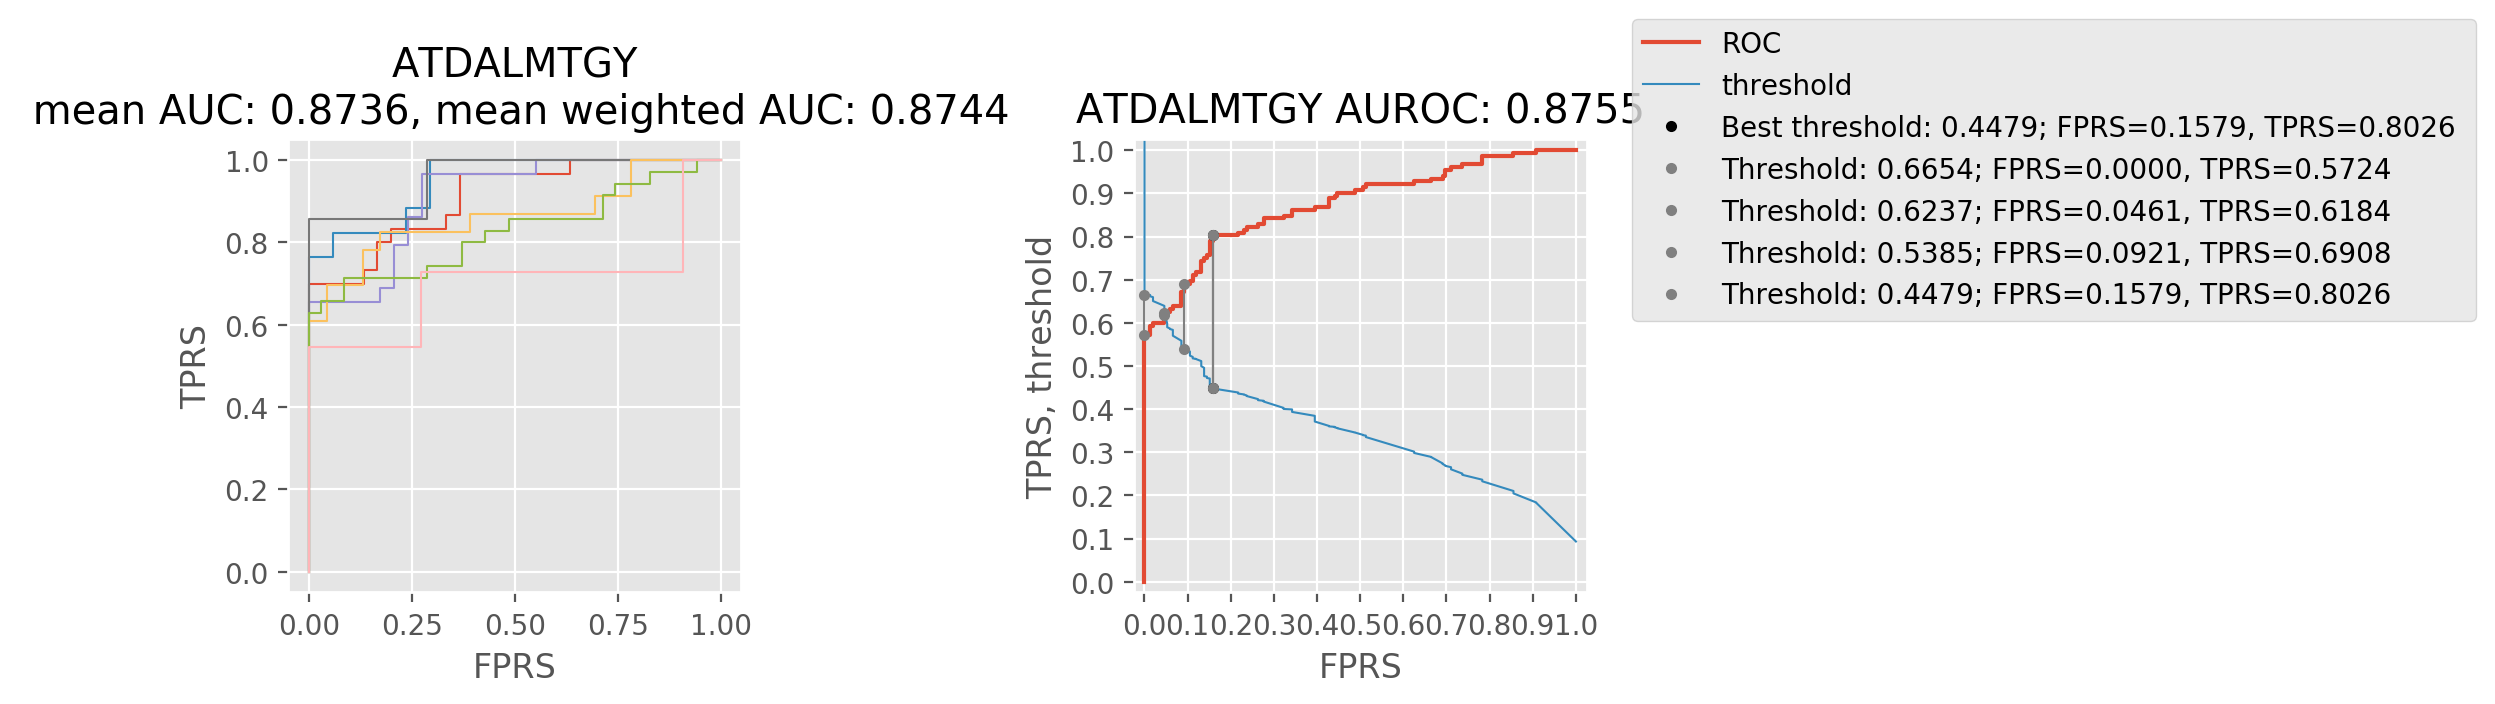

In [8]:
_,_,_,_ = tcrgp.loso('training_data/examples/vdj_human_ATDALMTGY.csv','human','ATDALMTGY',pc_blo,cdr_types=[[],['cdr3']],
                     m_iters=500,lr=0.005,nZ=0,mbs=0,va='va',vb='vb',cdr3a=None,cdr3b='cdr3b',epis='epitope',subs='subject')

* use all CDRS (CDR3$\beta$, CDR1$\beta$, CDR2$\beta$ and CDR2.5$\beta$, TCR$\alpha$ is not available)

human ATDALMTGY: 7 subjects, 152 positive and 152 control samples
All folds (7) computed.  


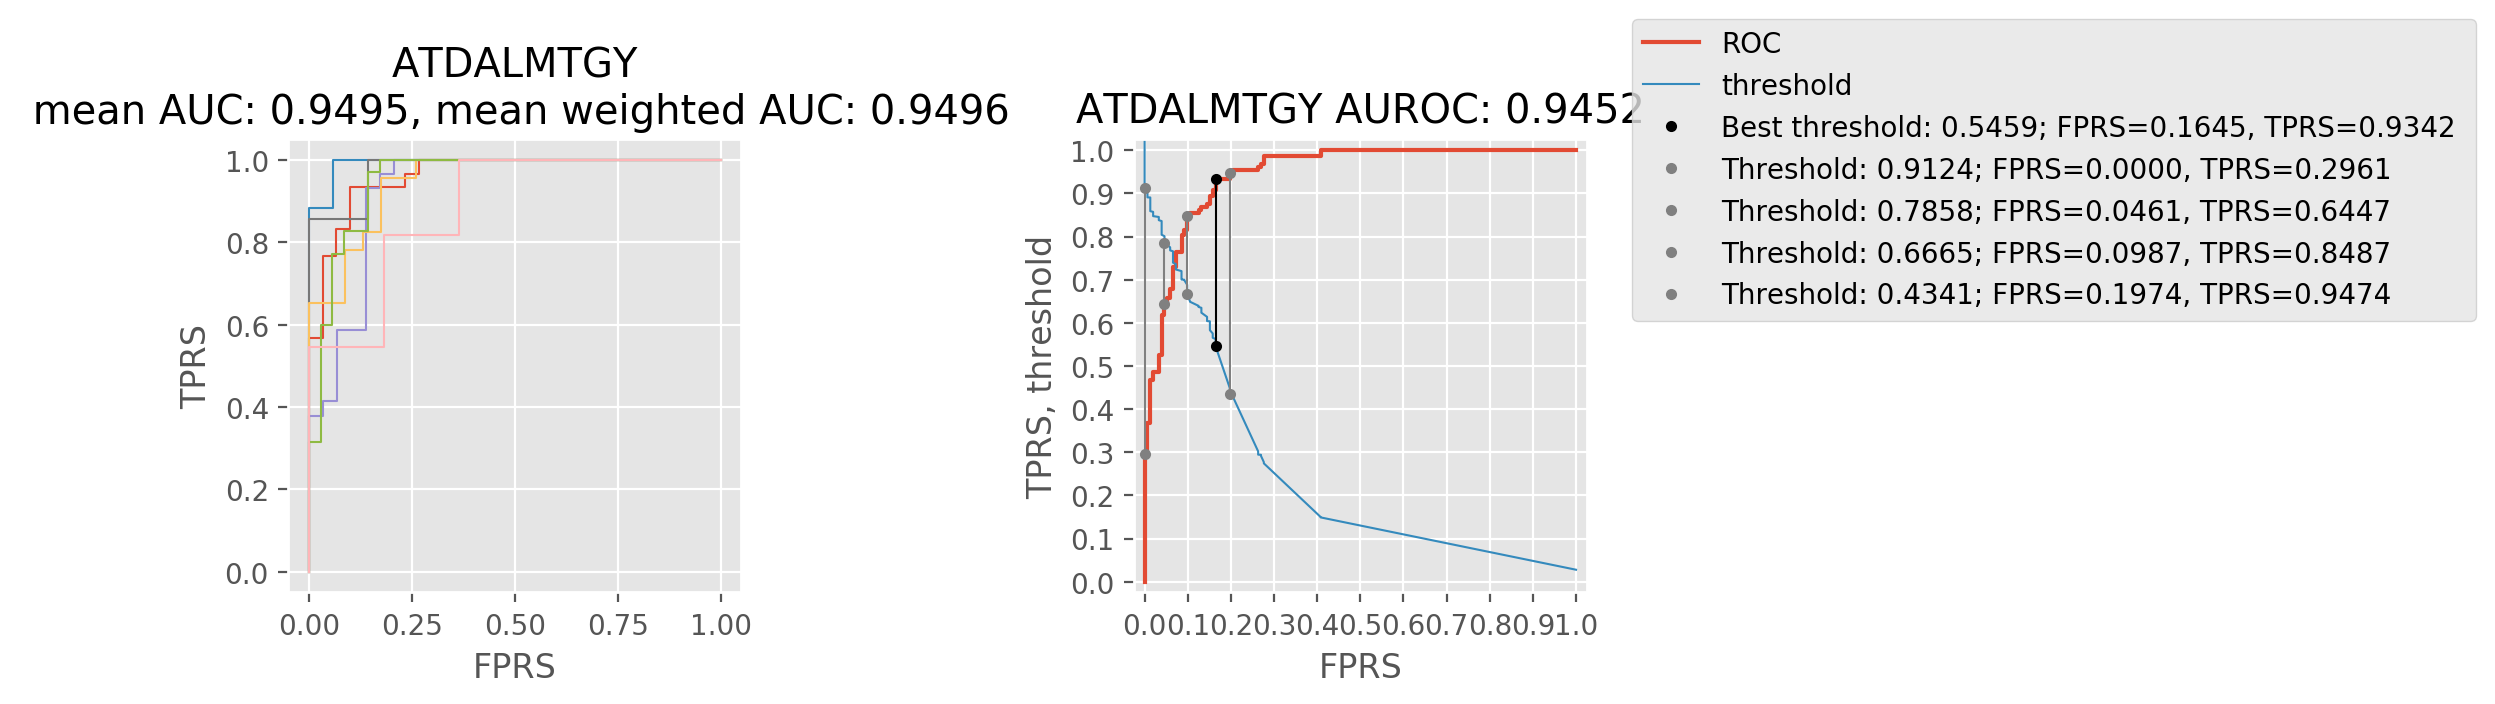

In [9]:
_,_,_,_ = tcrgp.loso('training_data/examples/vdj_human_ATDALMTGY.csv','human','ATDALMTGY',pc_blo,cdr_types=[[],['cdr3','cdr1','cdr2','cdr25']],
                     m_iters=500,lr=0.005,nZ=0,mbs=0,va=None,vb='vb',cdr3a=None,cdr3b='cdr3b',epis='epitope',subs='subject')

### Sparse model
* the method scales to larger data sets, when SVGP is used.
* nZ is a number of inducing points used, set it to something larger than 0, to start using SVGP
* mbs is the minibatch size used in training
* if nZ $\in (0,1)$, the number of inducing points is nZ times the number of training samples. Same applies for mbs


human ATDALMTGY: 7 subjects, 152 positive and 152 control samples
Computing fold: 1/7

/u/45/jokinee1/unix/.local/lib/python3.5/site-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


All folds (7) computed.  


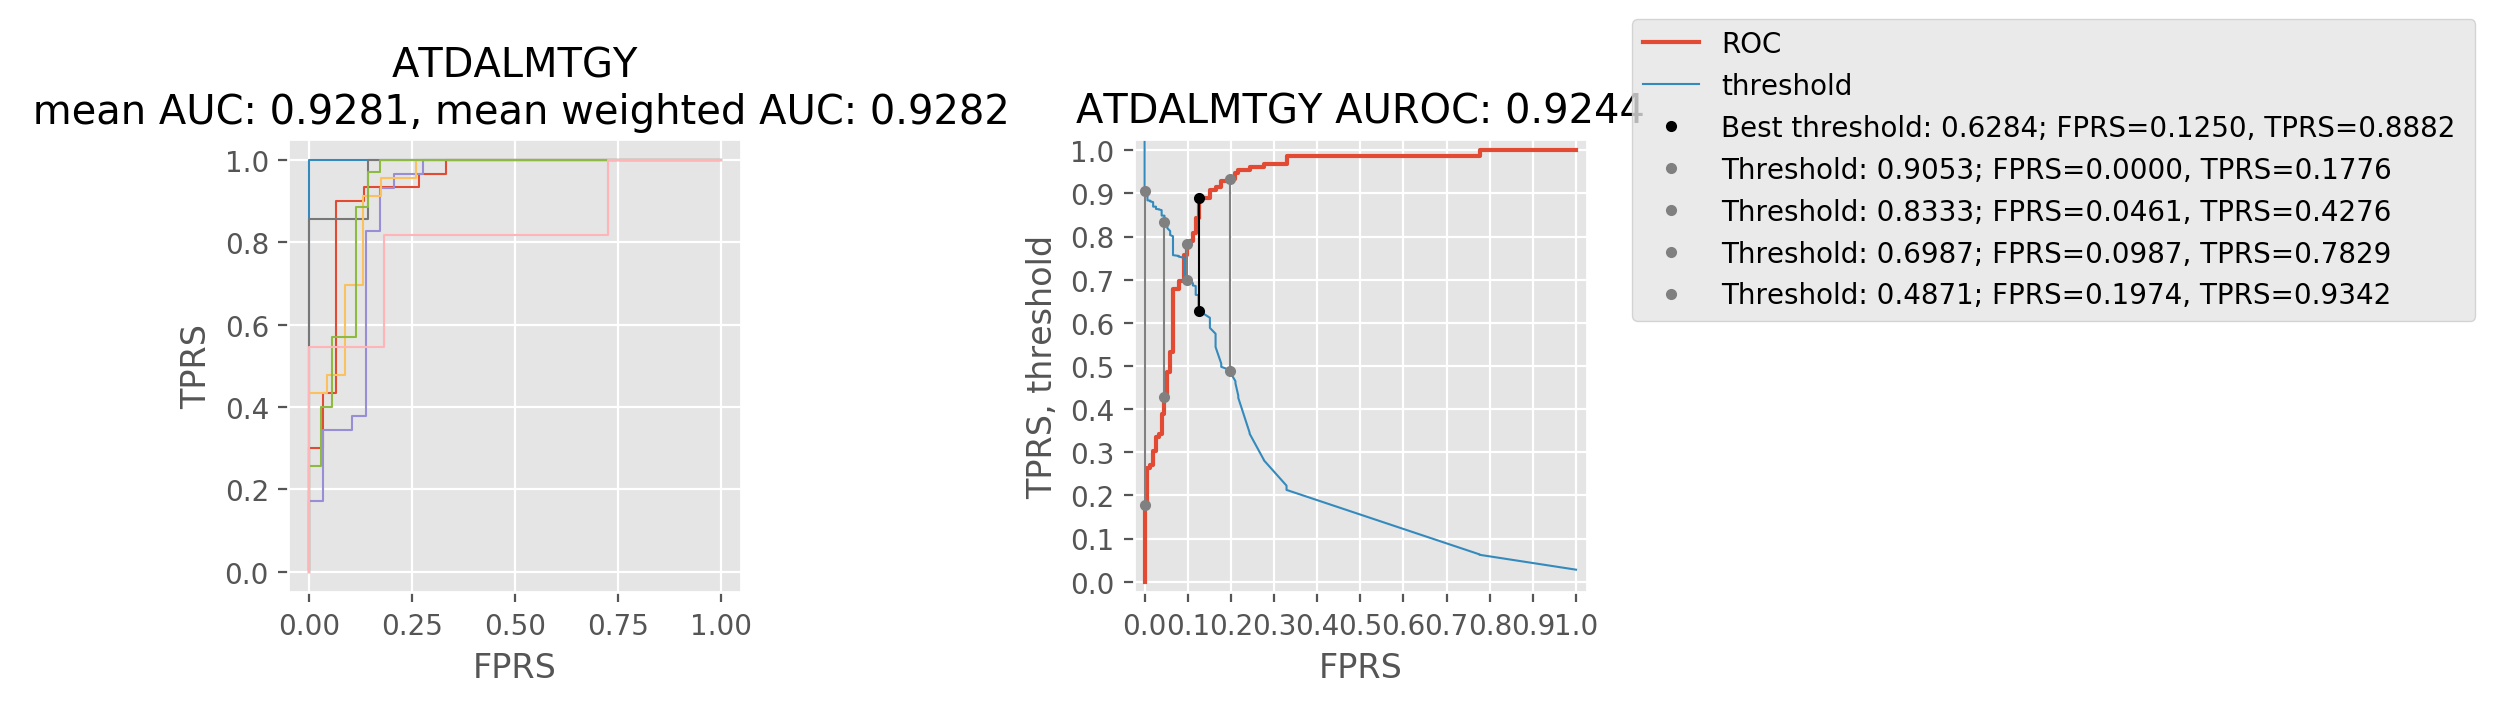

In [10]:
_,_,_,_ = tcrgp.loso('training_data/examples/vdj_human_ATDALMTGY.csv','human','ATDALMTGY',pc_blo,cdr_types=[[],['cdr3','cdr1','cdr2','cdr25']],
               m_iters=500,lr=0.005,nZ=60,mbs=100,va=None,vb='vb',cdr3a=None,cdr3b='cdr3b',epis='epitope',subs='subject')

## Training, saving and loading models
### Train the model with desired options
* auc is the AUC score for the training data
* params contains all necessary informatio for re-building the model
* Train with 5000 iterations and learning rate 0.005

In [11]:
auc, params = tcrgp.train_classifier('training_data/examples/vdj_human_ATDALMTGY.csv','human','ATDALMTGY',pc_blo,
                                     cdr_types=[[],['cdr3']],m_iters=5000,lr=0.005,nZ=0,mbs=0,lmax3=None,
                                     va='va',vb='vb',cdr3a='cdr3a',cdr3b='cdr3b',epis='epitope')

### Print model information
* which CDR-types are used, etc.

In [12]:
tcrgp.print_model_info(params)

CDR types: cdr3b 
max lengths: cdr3b: 20
number of training samples: 304 (152 positive, 152 negative)
number of inducing points: 0
minibatch size: 0
lengthscales: cdr3b: 3.8320 
kernel variances: cdr3b: 8.4130 
clip cdr3s: 0 from beginning, 0 from end


### Save the model parameters
* You can use for example pickle.dump to save the parameters to a file

In [13]:
with open('models/examples/models_vdj_ATDALMGTY_cdr3b','wb') as f:
    pickle.dump(params,f)

### Load the model parameters
* If you saved the parameters with pickle, you can now load them with pickle.load()

In [14]:
with open('models/examples/models_vdj_ATDALMGTY_cdr3b','rb') as f:
    params = pickle.load(f)

### Do predictions for new TCRs
* Now the loaded model can be used for any set of TCRs
* Here, just for an example, we have done the predictions for the same data

In [16]:
preds = tcrgp.predict('training_data/examples/vdj_human_ATDALMTGY.csv',params)

### Write results to file

In [20]:
cdr3bs=np.loadtxt('training_data/examples/vdj_human_ATDALMTGY.csv',dtype=str,comments=None,usecols=0,delimiter=',',skiprows=1)
with open('results/examples/results_vdj_ATDALMTGY.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')   
    writer.writerow(['CDR3B','prediction'])
    for s,p in zip(cdr3bs,preds):
        writer.writerow([s,'{:.4f}'.format(p[0])])

# Experiment with the human TCRs from Dash et al. [3]

In [21]:
tcrs_dash_human = tcrgp.file2dict('data/human_pairseqs_v1_parsed_seqs_probs_mq20_clones.tsv',['epitope'],['subject','va_gene','vb_gene','cdr3a','cdr3b'])
epis_dash_human = list(tcrs_dash_human.keys())
for epi in epis_dash_human:
    n_e = len(tcrs_dash_human[epi])
    subs=[s[0] for s in tcrs_dash_human[epi]]
    n_s = len(np.unique(subs))
    print(epi+': '+str(n_s)+' subjects and '+str(n_e)+' samples')

M1: 15 subjects and 275 samples
BMLF: 6 subjects and 76 samples
pp65: 10 subjects and 61 samples


## Write data files
Create a separate data file for each epitope. Add epitope-specific TCRs and control TCRs.


In [22]:
for epi in epis_dash_human:
    n_e = len(tcrs_dash_human[epi])
    with open('training_data/examples/dash_human_'+epi+'.csv','w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['Epitope','Subject','va','vb','cdr3a','cdr3b'])
        for row in tcrs_dash_human[epi]:
            writer.writerow([epi,row[0],row[1],row[2],row[3],row[4]])
        for i in np.random.choice(range(n_controls),n_e).astype(int):
            writer.writerow(['none','control']+controls[i])

# Leave-one-subject-out cross-validations
Leave-one-subject-out (loso) cross-validations can be used to evaluate the performance of the model.

## Train model with human TCRs recognizing BMLF (GLCTLVAML) from VDJdb
* use only CDR3$\beta$
* use max. 500 iterations and learning rate 0.005 (We used 5000 iterations in [1])

human BMLF: 6 subjects, 76 positive and 76 control samples
All folds (6) computed.  


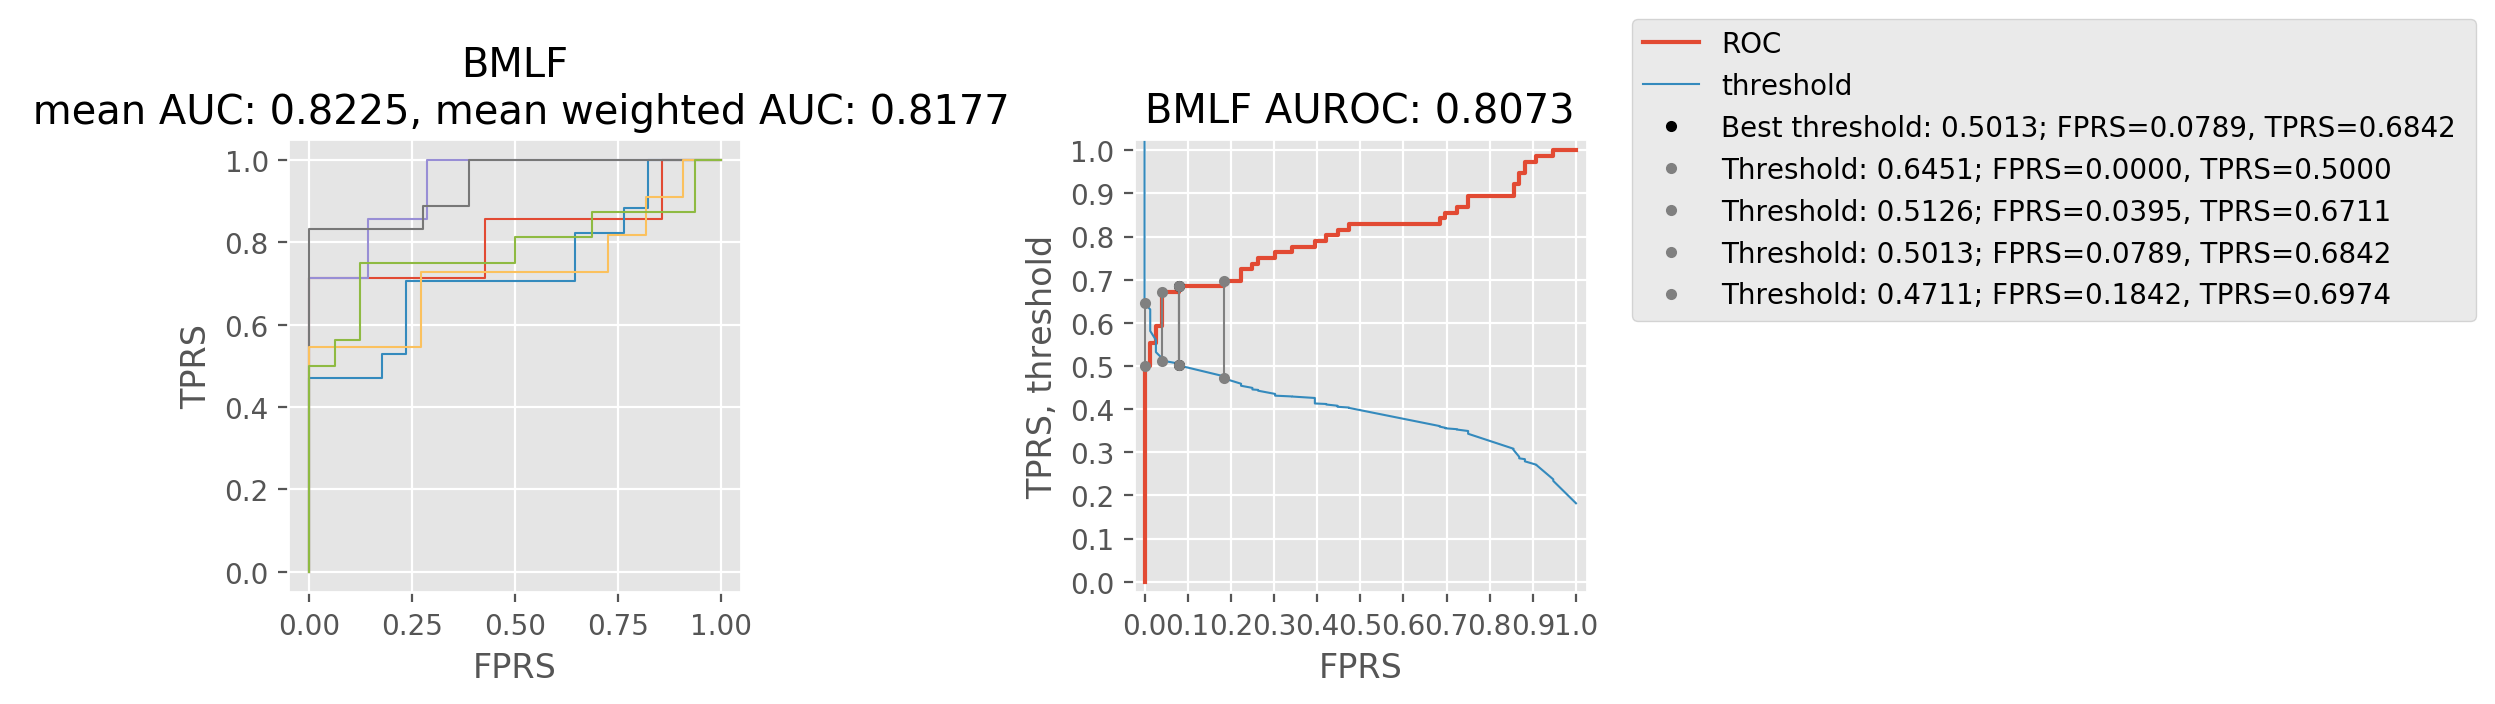

In [23]:
_,_,_,_ = tcrgp.loso('training_data/examples/dash_human_BMLF.csv','human','BMLF',pc_blo,cdr_types=[[],['cdr3']],
                     m_iters=500,lr=0.005,nZ=0,mbs=0,va=None,vb=None,cdr3a=None,cdr3b='cdr3b',epis='Epitope',subs='Subject')

* use CDR3$\alpha$ and CDR3$\beta$
* use max. 500 iterations and learning rate 0.005

human BMLF: 6 subjects, 76 positive and 76 control samples
All folds (6) computed.  


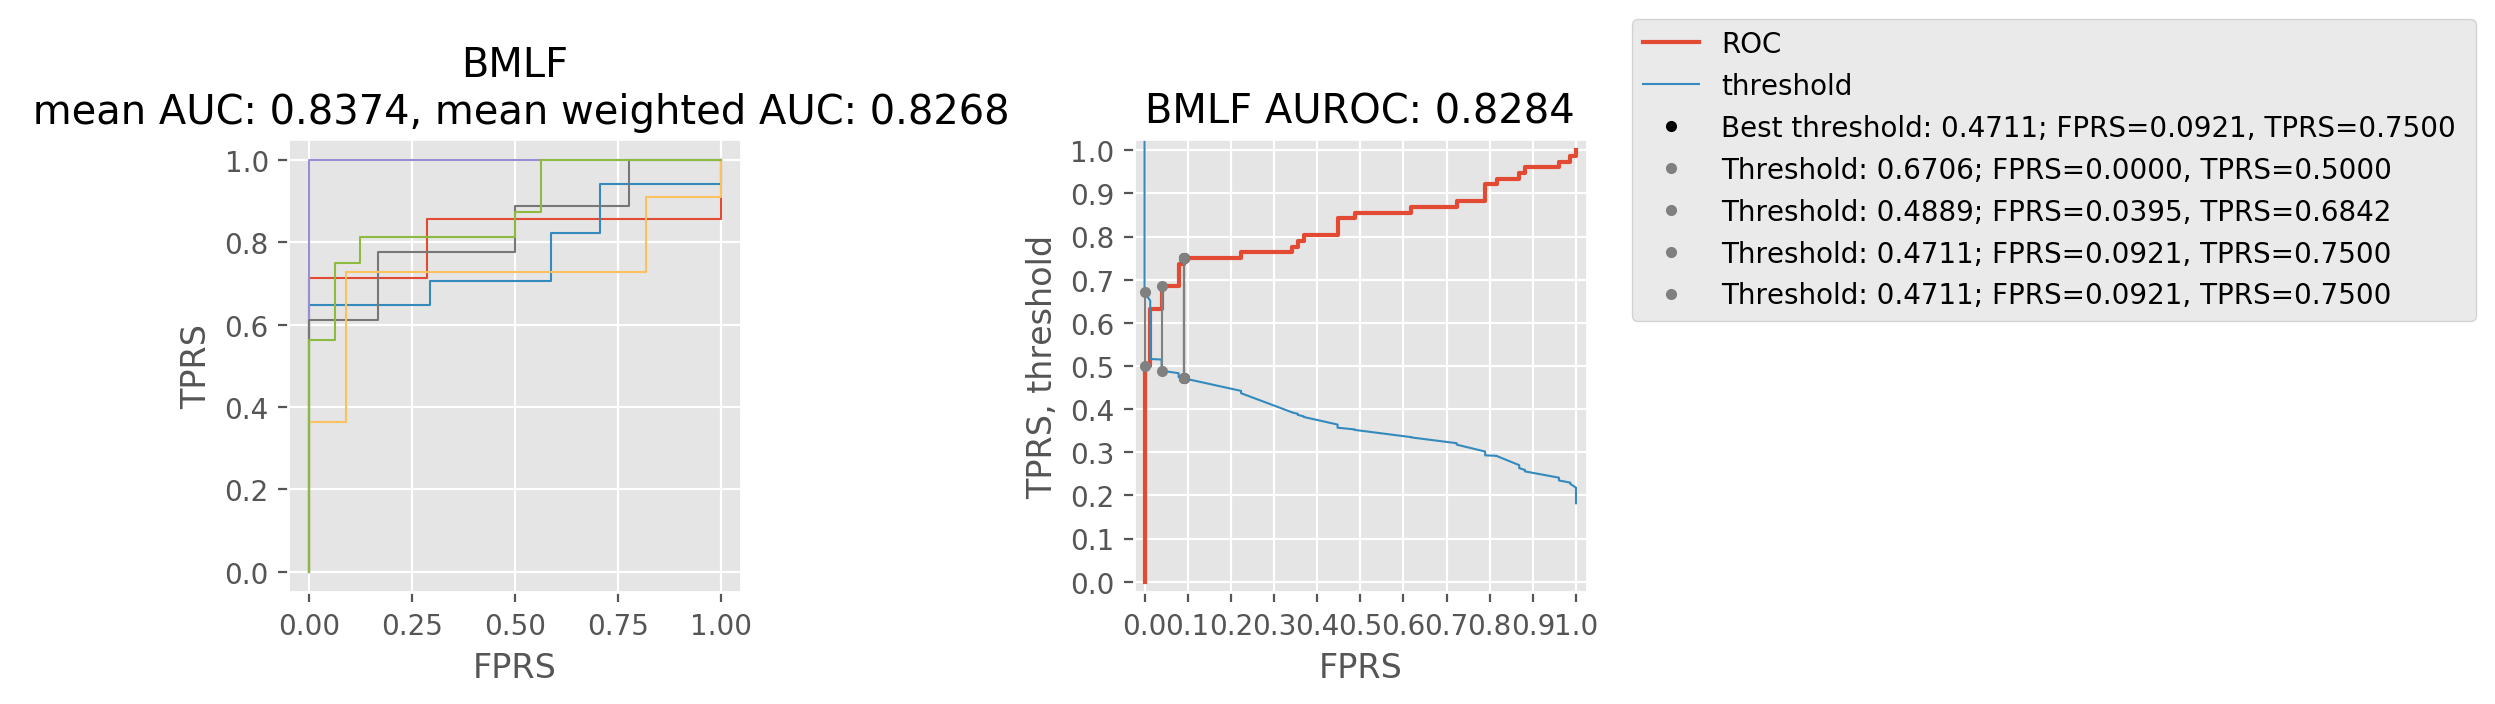

In [24]:
_,_,_,_ = tcrgp.loso('training_data/examples/dash_human_BMLF.csv','human','BMLF',pc_blo,cdr_types=[['cdr3'],['cdr3']],
                     m_iters=500,lr=0.005,nZ=0,mbs=0,va=None,vb=None,cdr3a='cdr3a',cdr3b='cdr3b',epis='Epitope',subs='Subject')

* Use all CDRs from $\alpha$- and $\beta$-chains

human BMLF: 6 subjects, 76 positive and 76 control samples
All folds (6) computed.  


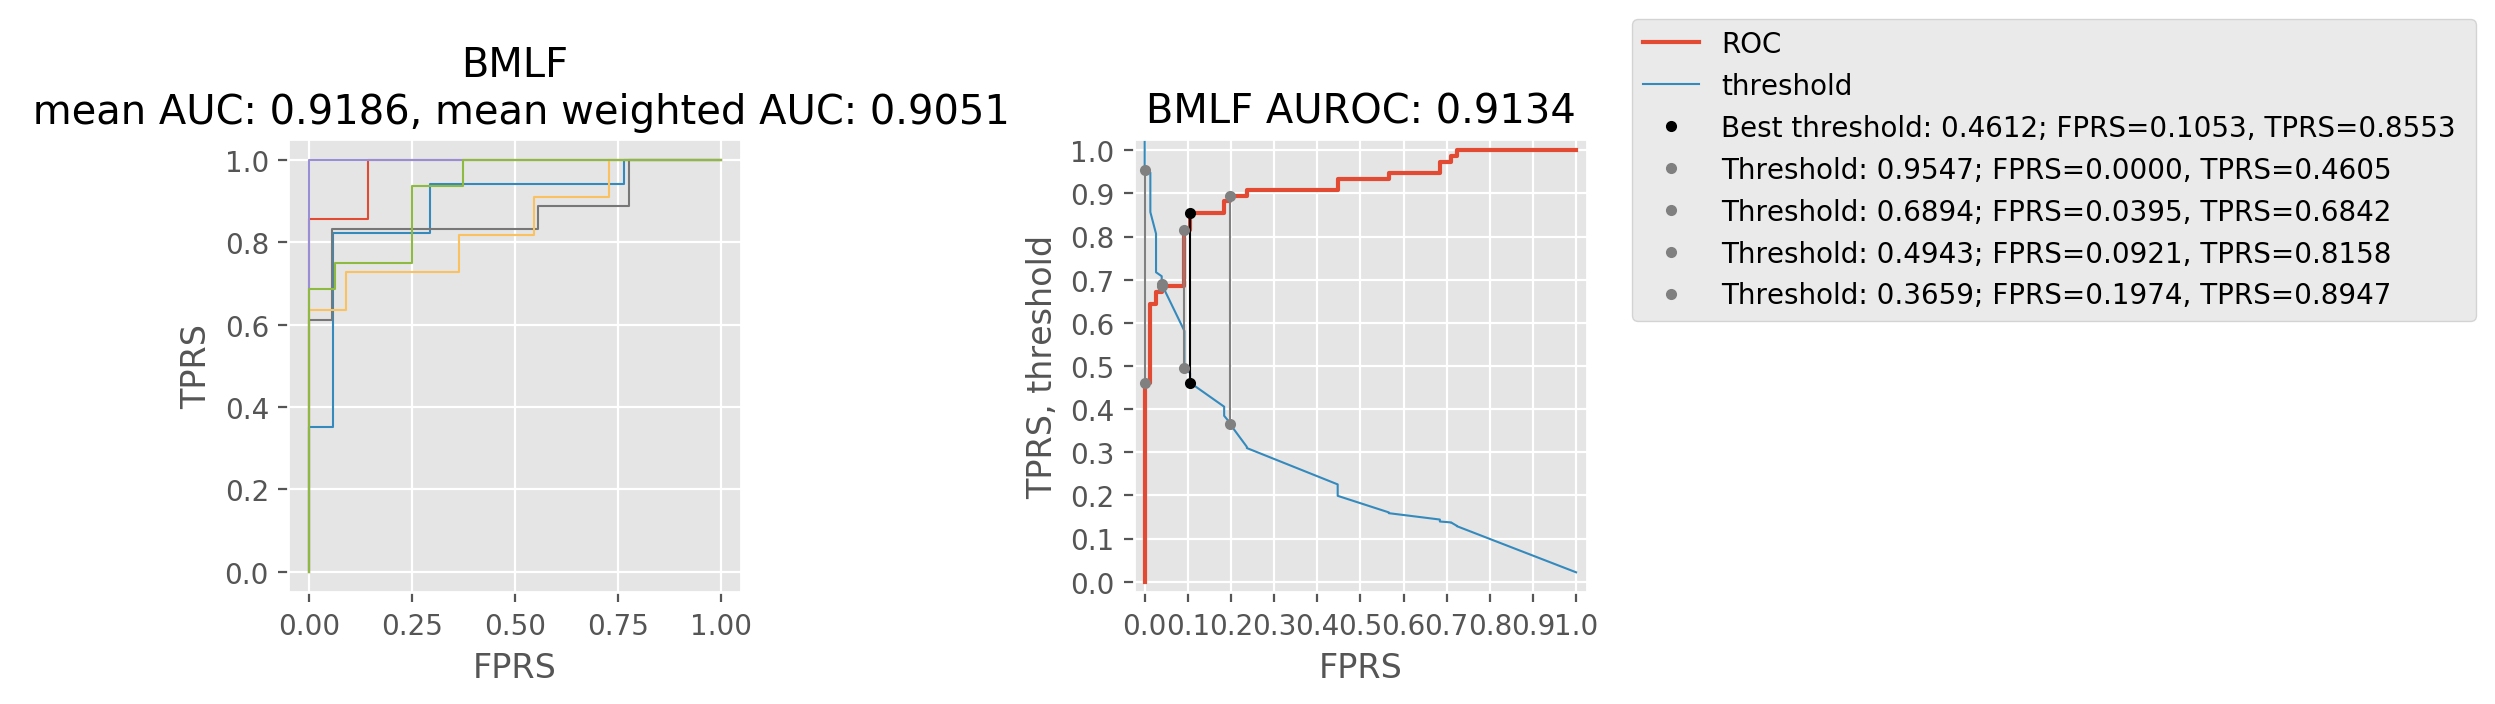

In [25]:
_,_,_,_ = tcrgp.loso('training_data/examples/dash_human_BMLF.csv','human','BMLF',pc_blo,cdr_types=[['cdr3','cdr1','cdr2','cdr25'],['cdr3','cdr1','cdr2','cdr25']],
                     m_iters=500,lr=0.005,nZ=0,mbs=0,va='va',vb='vb',cdr3a='cdr3a',cdr3b='cdr3b',epis='Epitope',subs='Subject')

## Compute diversities 

In [26]:
peps='pp65$_{123-131}$ pp65$_{417-426}$ pp65$_{495-503}$ BMLF1$_{280-288}$ BZLF1$_{190-197}$ BRLF1$_{109-117}$ M1$_{58-66}$ HA$_{306-318}$ NS3$_{1073-1081}$ NS3$_{1406-1415}$ NS3$_{1436-1444}$ VP22$_{49-57}$ NS4B$_{214-222}$ NS3$_{133-142}$ NS3$_{133-142}$ p24$_{30-40}$ p24$_{48-56}$ p24$_{128-135}$ p24$_{131-140}$ p24$_{161-180}$ p24$_{223-231}$ Nef$_{90-97}$'
peps=peps.split()

virus='CMV CMV CMV EBV EBV EBV IAV IAV HCV HCV HCV HSV-2 YFV DENV1 DENV3-4 HIV-1 HIV-1 HIV-1 HIV-1 HIV-1 HIV-1 HIV-1'
virus=[v.strip() for v in virus.split()]

epitopes='IPSINVHHY TPRVTGGGAM NLVPMVATV GLCTLVAML RAKFKQLL YVLDHLIVV GILGFVFTL PKYVKQNTLKLAT CINGVCWTV KLVALGINAV ATDALMTGY RPRGEVRFL LLWNGPMAV GTSGSPIVNR GTSGSPIINR KAFSPEVIPMF TPQDLNTML EIYKRWII KRWIILGLNK FRDYVDRFYKTLRAEQASQE GPGHKARVL FLKEKGGL'
epitopes=epitopes.split()

In [27]:
div_mats,divs_mean,divs_Kmany=[],[],[] # lists for gathering computed diversities
# For comparability we use same parameters for each epitope
# These are mean lengthscale and mean kernel variance for the 22 epitopes in the VDJdb data
ls,v = 2.499, 5.524 
for epi in epitopes[:20]+epitopes[21:]: # GPGHKARVL has only one subject, so it has been left out here
    datafile='training_data/vdj_human_'+epi+'.csv'
    epis,subs,cdrs,lmaxes,_ = tcrgp.get_sequence_lists(datafile,'human',epi,[[],['cdr3']],',',[0,0],subs='subject')
    cdr3s = cdrs[0][:sum(epis==epi)] # Select epitope-specific TCRs
    X = tcrgp.encode_with_pc([cdr3s],lmaxes,pc_blo)
    k = tcrgp.construct_rbf_kernel(21,lmaxes,[ls],[v])
    K = k.compute_K(X,X)
    
    subs=subs[epis==epi]
    usubs=np.unique(subs)
    nsu=len(usubs)
    Isubs=np.zeros((len(subs),),dtype=int)
    divs=np.ones((nsu,nsu))*np.nan
    Inot=np.zeros((nsu,),dtype=bool)
    for i in range(nsu):
        I1 = subs==usubs[i]
        Isubs[I1]=i
        if sum(I1)<2: # if less than two TCRs for a subject, don't compute diversity
            Inot[i]=True
            continue
        divs[i,i] = tcrgp.diversity_K(K[I1,:][:,I1])
        for j in range(i+1,nsu):
            I2 = subs==usubs[j]
            if sum(I1)<2: # if less than two TCRs for a subject, don't compute diversity
                continue
            div=tcrgp.diversity_K2(K[I1,:][:,I2],mintcrs=2)
            divs[i,j]=div
            divs[j,i]=div
    div_mats.append(divs[~Inot,:][:,~Inot])
    divs_mean.append(np.mean(np.diag(divs[~Inot,:][:,~Inot]))) # mean diversity within subjects
    divs_Kmany.append(tcrgp.diversity_Kmany(K,Isubs)) # diversity between all subjects


### Plot mean diversity within subjects and diversity between all subjects for the selected epitopes

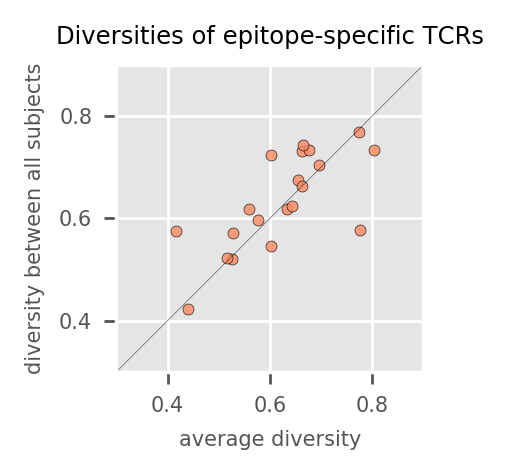

In [28]:
plt.figure(figsize=(2,2),dpi=250)

xy1,xy2 =0.3,0.9 # set limits for x and y axes
plt.plot([xy1,xy2],[xy1,xy2],'k',linewidth=0.2,alpha=0.6)
plt.scatter(divs_mean,divs_Kmany,s=10,alpha=0.8,edgecolors='k',linewidths=0.2,c=[[0.9867, 0.535582, 0.38221]])
plt.axis('square')
plt.xticks(np.arange(0.2,1.1,0.2),fontsize=6)
plt.yticks(np.arange(0.2,1.1,0.2),fontsize=6)
plt.xlim([xy1,xy2])
plt.ylim([xy1,xy2])
plt.title('Diversities of epitope-specific TCRs',fontsize=7)
plt.xlabel('average diversity',fontsize=6)
plt.ylabel('diversity between all subjects',fontsize=6)
plt.tight_layout()

plt.show()

### Plot diversities between pairs of subjects for the selected epitopes

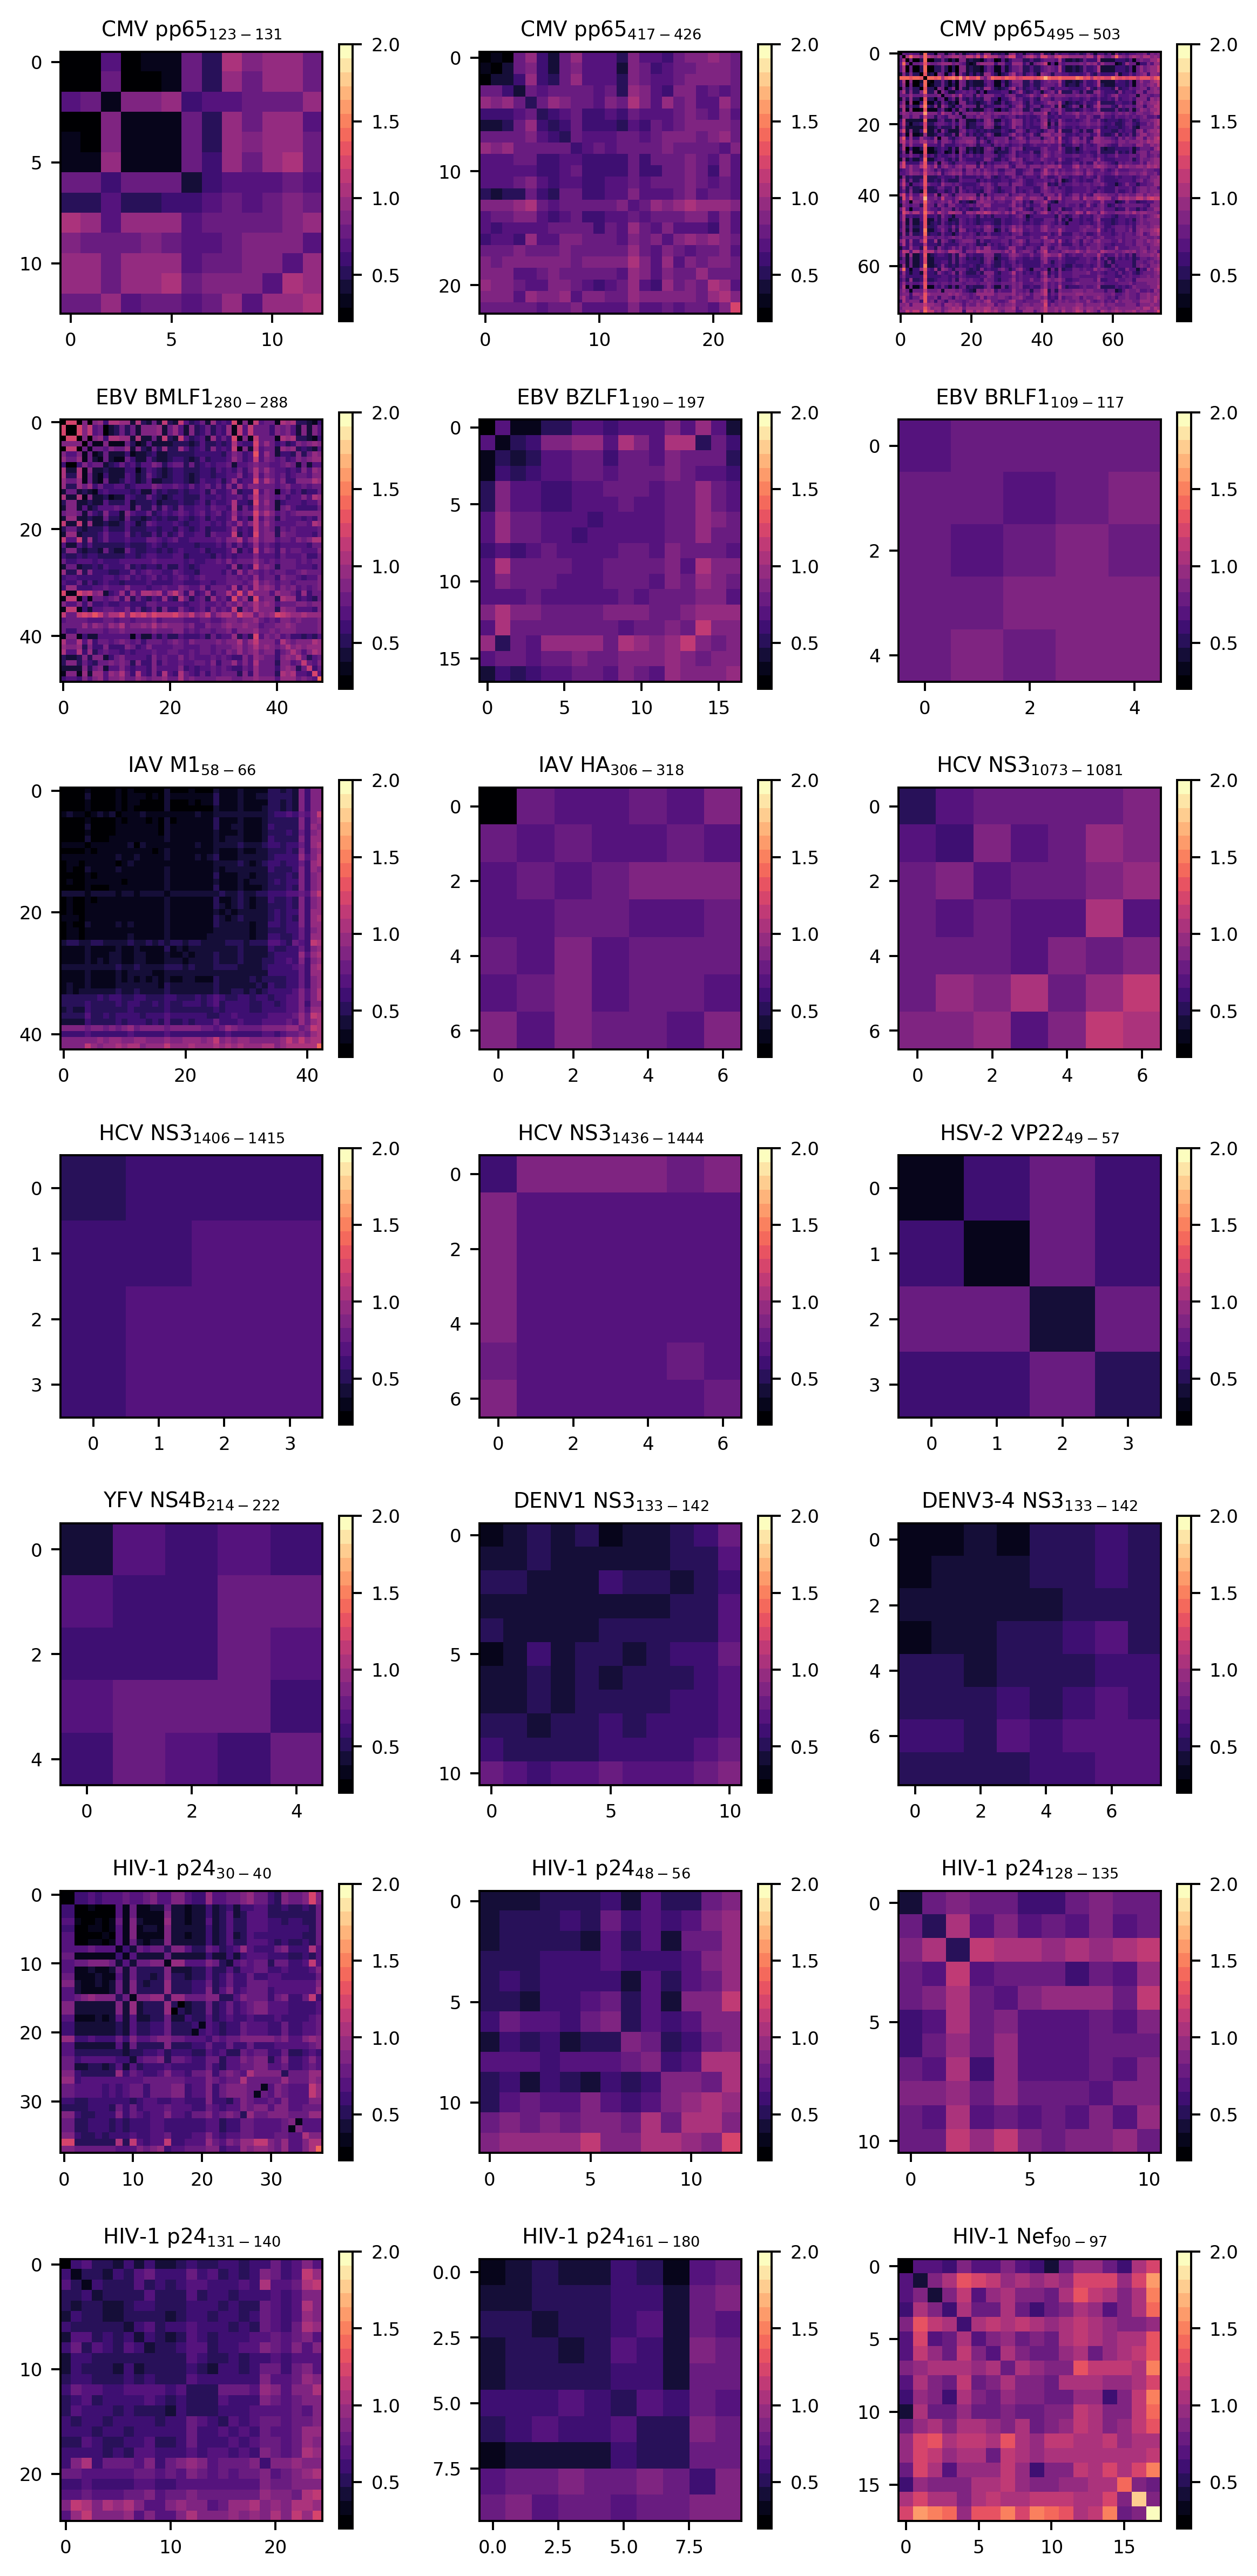

In [29]:
plt.figure(figsize=(172/25.4,350/25.4),dpi=350)
plt.style.use('default')
plt.set_cmap(plt.get_cmap('inferno',10))
ind=1
for divs,epi,epi_name in zip(div_mats, epitopes[:20]+epitopes[21:],
        [c+' '+v for c, v in zip(virus[:20]+virus[21:],peps[:20]+peps[21:])]):
    
    plt.subplot(7,3,ind)
    plt.title(epi_name,fontsize=8)
    dia=np.diagonal(divs)
    I=np.argsort(dia)
    plt.imshow(divs[I,:][:,I],interpolation='nearest', cmap=plt.get_cmap('magma',20))
    
    plt.clim([0.2,2])
    plt.yticks(fontsize=7)
    plt.xticks(plt.gca().get_yticks()[1:-1],fontsize=7)
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=7)
    ind+=1
    
plt.tight_layout()
plt.show()

# References
[1] Emmi Jokinen, Jani Huuhtanen, Markus Heinonen, Satu Mustjoki and Harri Lähdesmäki. (2020). Predicting recognition between T cell receptors and epitopes with TCRGP. (submitted)

[2] Shugay, M. *et al.* (2017). VDJdb: a curated database of T-cell receptor sequences with known antigen specificity. *Nucleic acids research,* **46**(D1), D419-D427

[3] Dash, P. *et al.* (2017). Quantifiable predictive features define epitope-specific T cell receptor repertoires. *Nature*, **547**(7661), 89